In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

c:\Users\CaiLab\anaconda3\envs\ImageAnalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> GPU activated? 1
2023-12-06 11:53:23,893 [INFO] WRITING LOG OUTPUT TO C:\Users\CaiLab\.cellpose\run.log
2023-12-06 11:53:23,894 [INFO] 
cellpose version: 	2.2.2 
platform:       	win32 
python version: 	3.8.17 
torch version:  	1.12.0


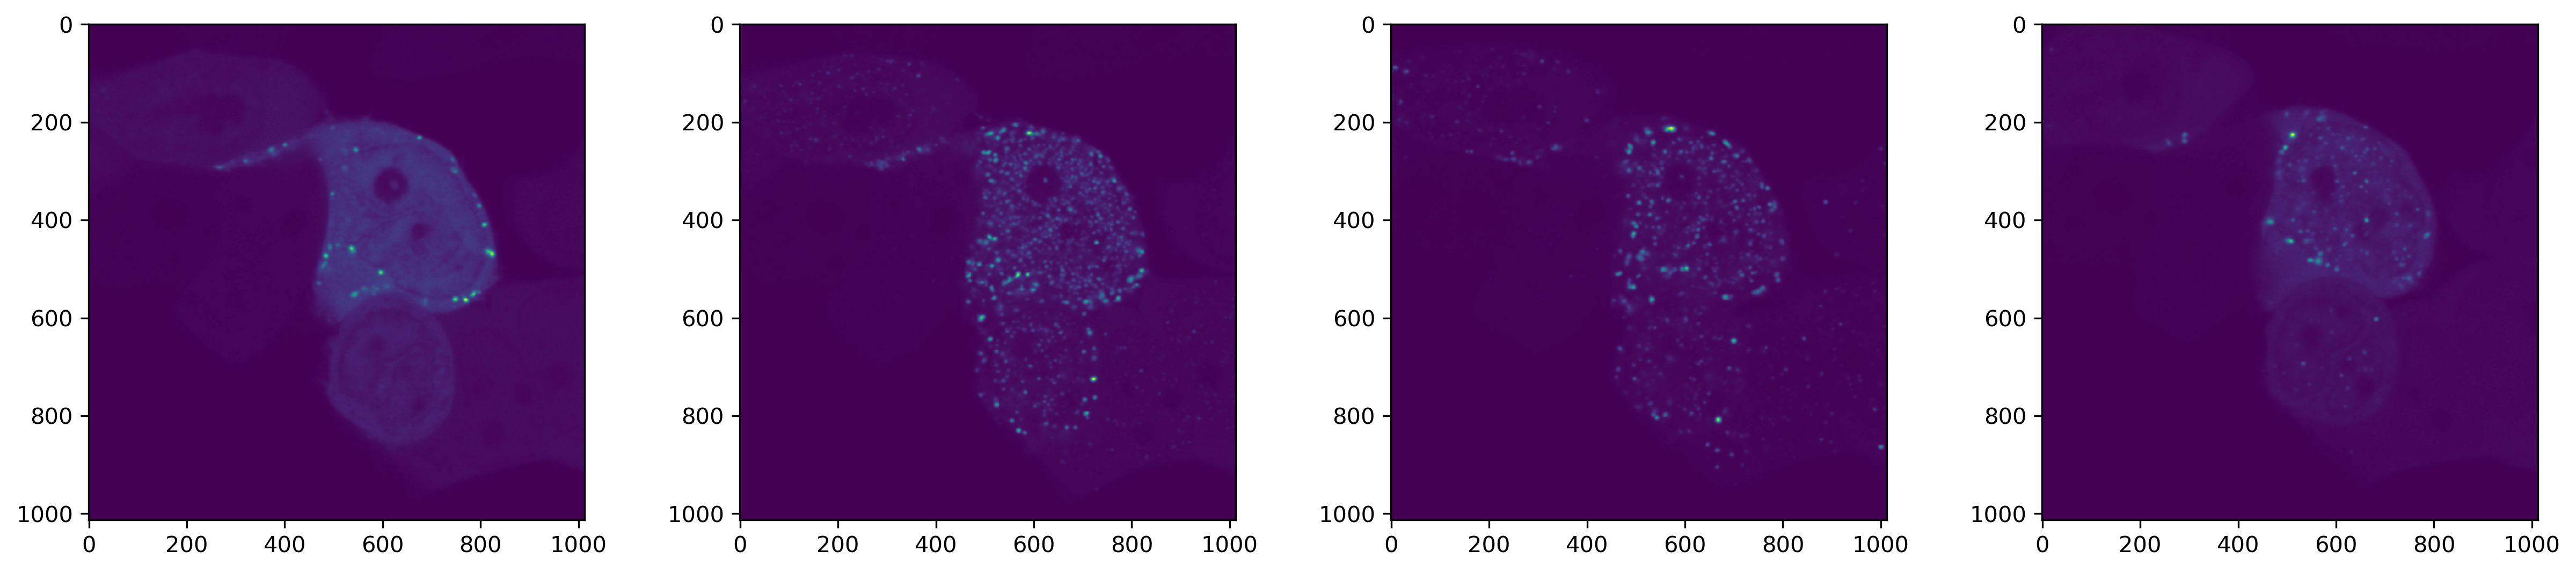

In [2]:
from cellpose import utils
# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png',
        'http://www.cellpose.org/static/data/rgb_3D.tif']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
files = ["file.ome.tif","file2.ome.tif","file10.ome.tif","file20.ome.tif"]
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(20,4))
for k,img in enumerate(imgs):
  plt.subplot(1,4,k+1)
  plt.imshow(img)

In [3]:
# RUN CELLPOSE

imgs_2D = imgs

from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs_2D, diameter=None, flow_threshold=None, channels=channels)


2023-12-06 11:53:25,601 [INFO] ** TORCH CUDA version installed and working. **
2023-12-06 11:53:25,604 [INFO] >>>> using GPU
2023-12-06 11:53:25,606 [INFO] >> cyto << model set to be used
2023-12-06 11:53:26,857 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-12-06 11:53:26,859 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2023-12-06 11:53:37,193 [INFO] 100%|##########| 4/4 [00:10<00:00,  2.58s/it]
2023-12-06 11:53:37,194 [INFO] estimated cell diameter(s) in 10.34 sec
2023-12-06 11:53:37,195 [INFO] >>> diameter(s) = 
2023-12-06 11:53:37,196 [INFO] [39.89, 14.67, 14.41, 24.57, ]
2023-12-06 11:53:37,197 [INFO] ~~~ FINDING MASKS ~~~
2023-12-06 11:53:43,536 [INFO] 100%|##########| 4/4 [00:06<00:00,  1.58s/it]
2023-12-06 11:53:43,537 [INFO] >>>> TOTAL TIME 16.68 sec


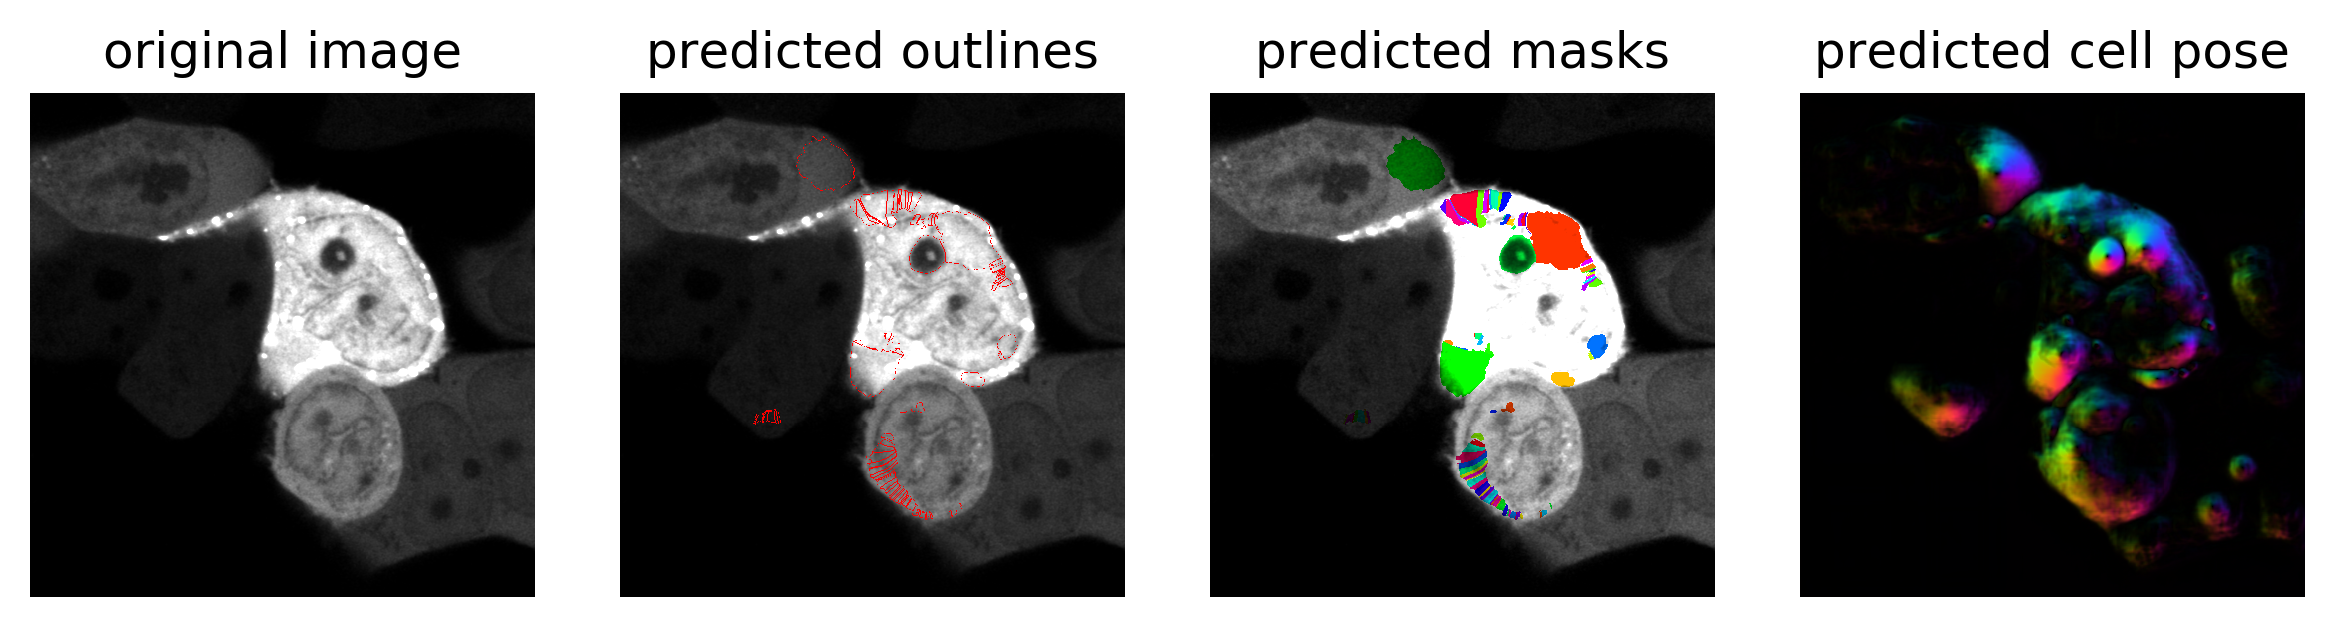

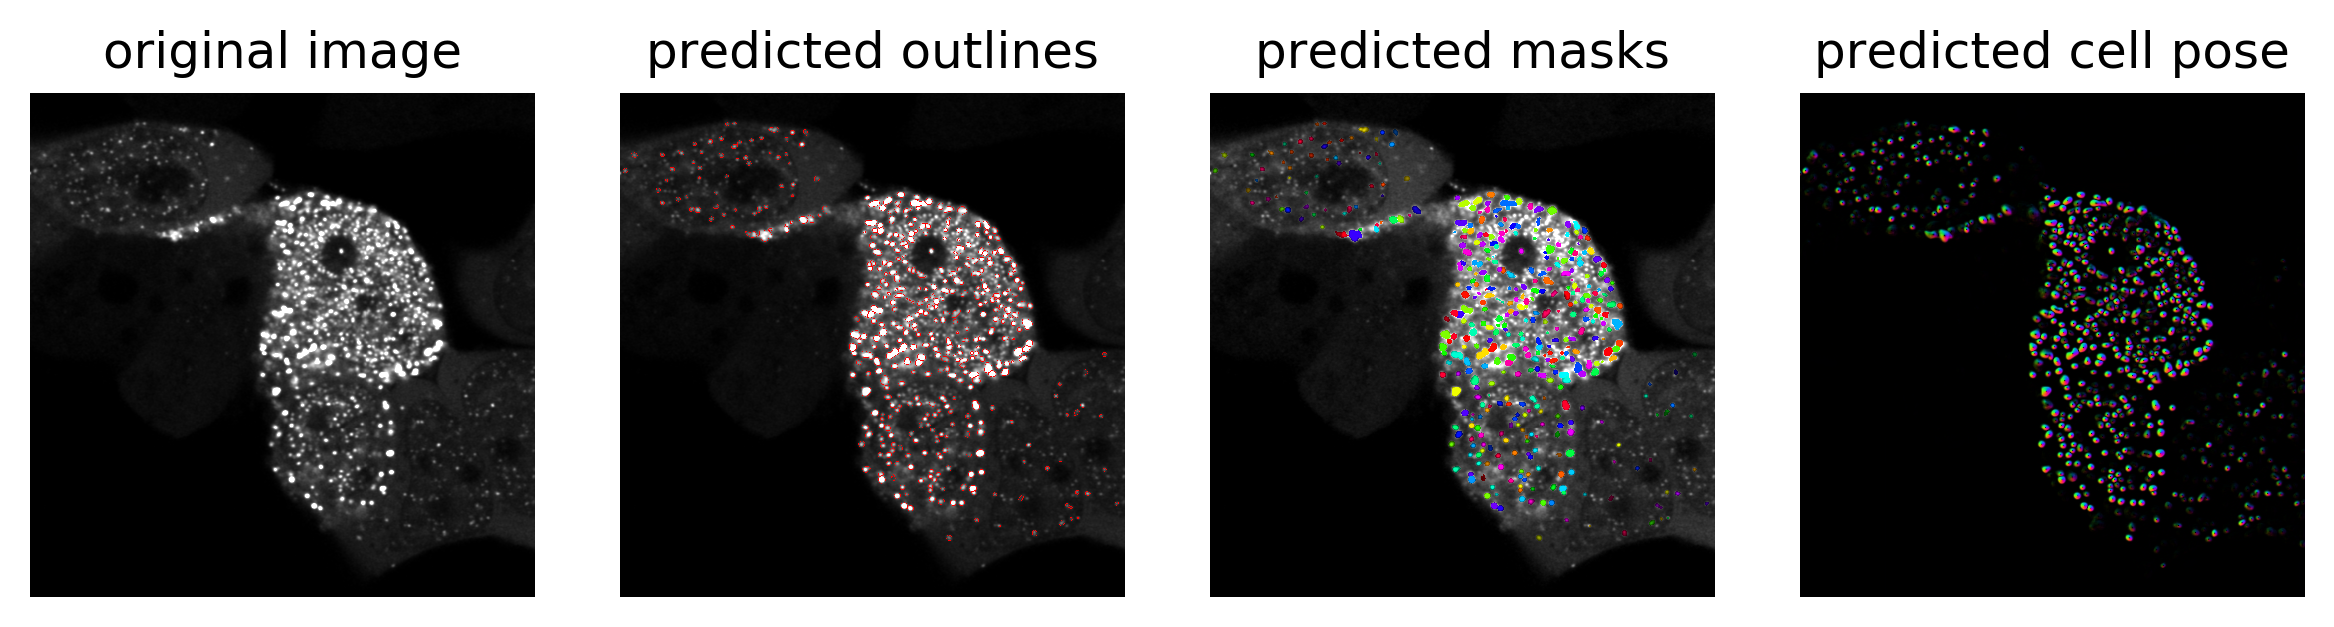

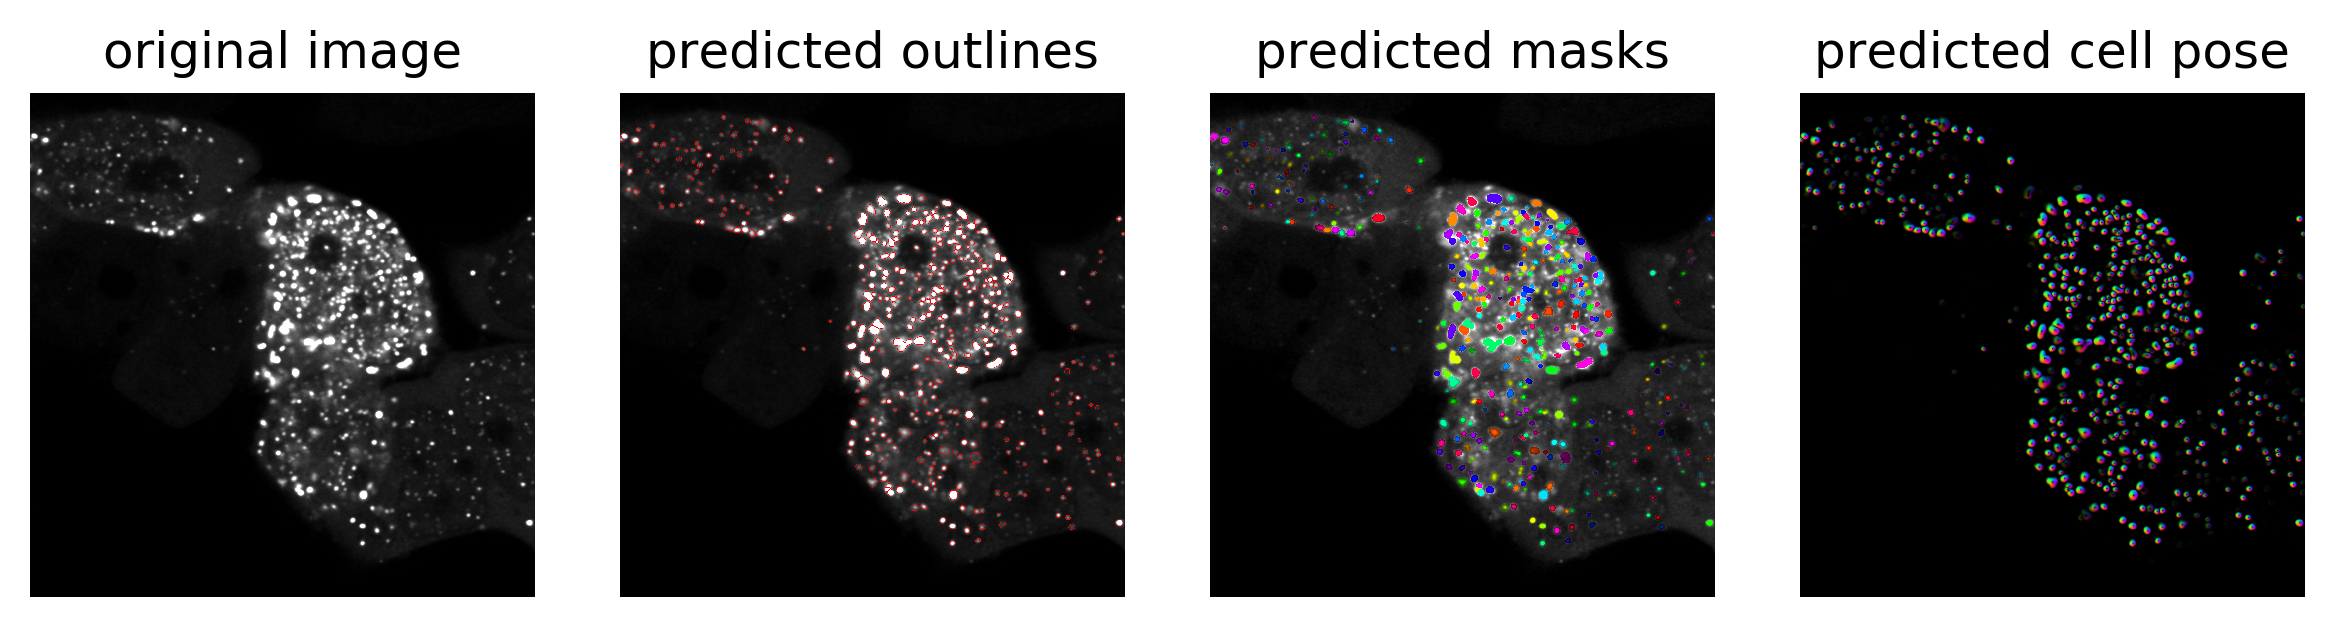

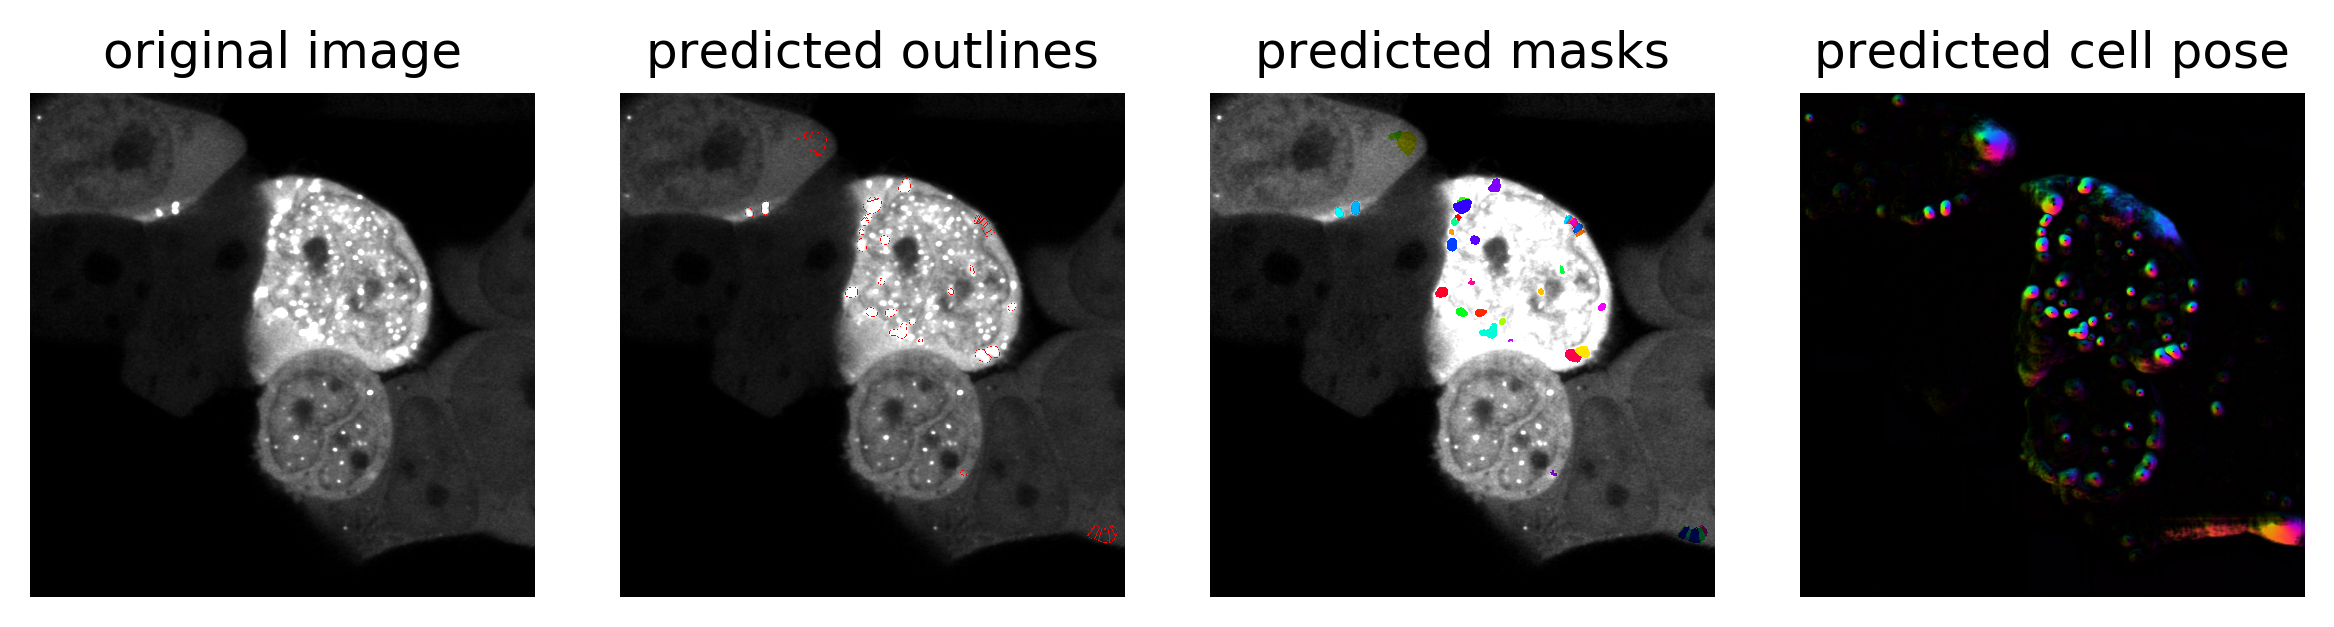

In [4]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs_2D)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(8,3))
    # plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    plt.show()

## Using Custom Modules

In [5]:
imgs_2D = imgs

from cellpose import models

# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model="./CP_testJIL_epoch500")

# use model diameter if user diameter is 0
diameter = model.diam_labels 

print()
# run model on test images
masks, flows, styles = model.eval(imgs_2D, 
                                  channels=channels,
                                  diameter=diameter,
                                  )

2023-12-05 13:03:23,969 [INFO] >>>> loading model ./CP_testJIL_epoch500
2023-12-05 13:03:23,974 [INFO] ** TORCH CUDA version installed and working. **
2023-12-05 13:03:23,976 [INFO] >>>> using GPU
2023-12-05 13:03:24,219 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-12-05 13:03:24,221 [INFO] >>>> model diam_labels =  296.739 (mean diameter of training ROIs)

2023-12-05 13:03:34,638 [INFO] 100%|##########| 4/4 [00:10<00:00,  2.60s/it]


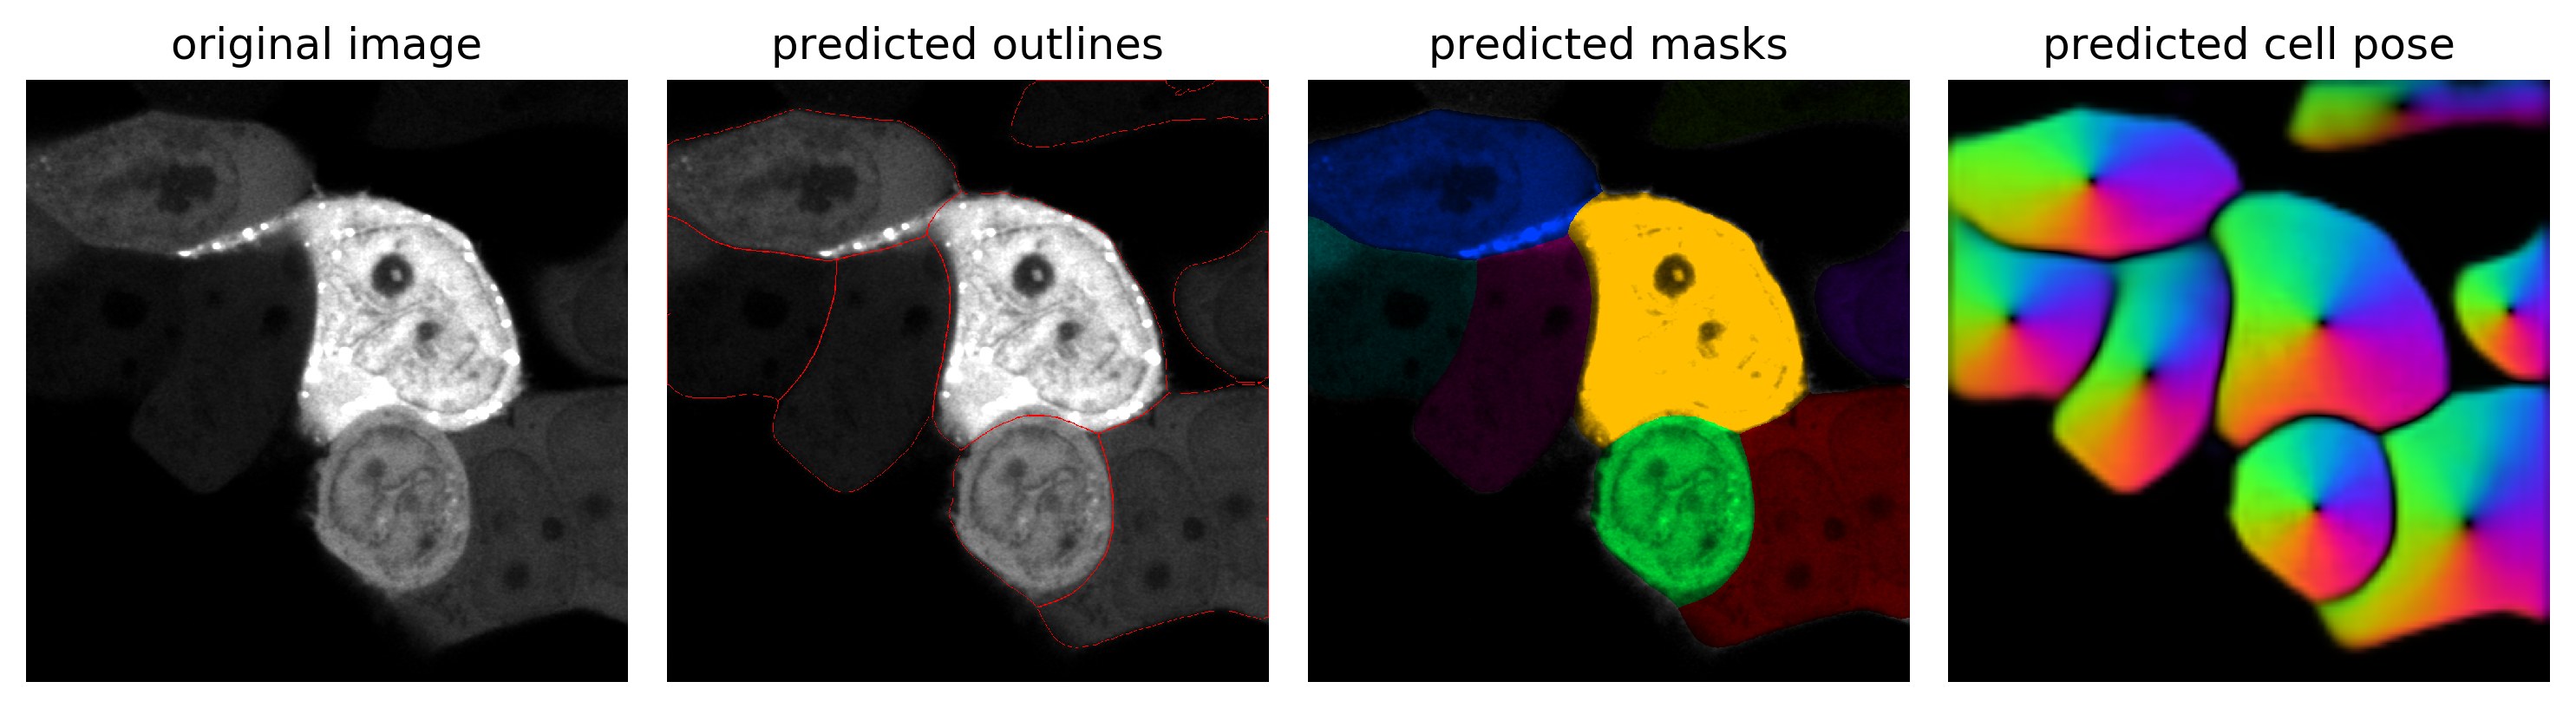

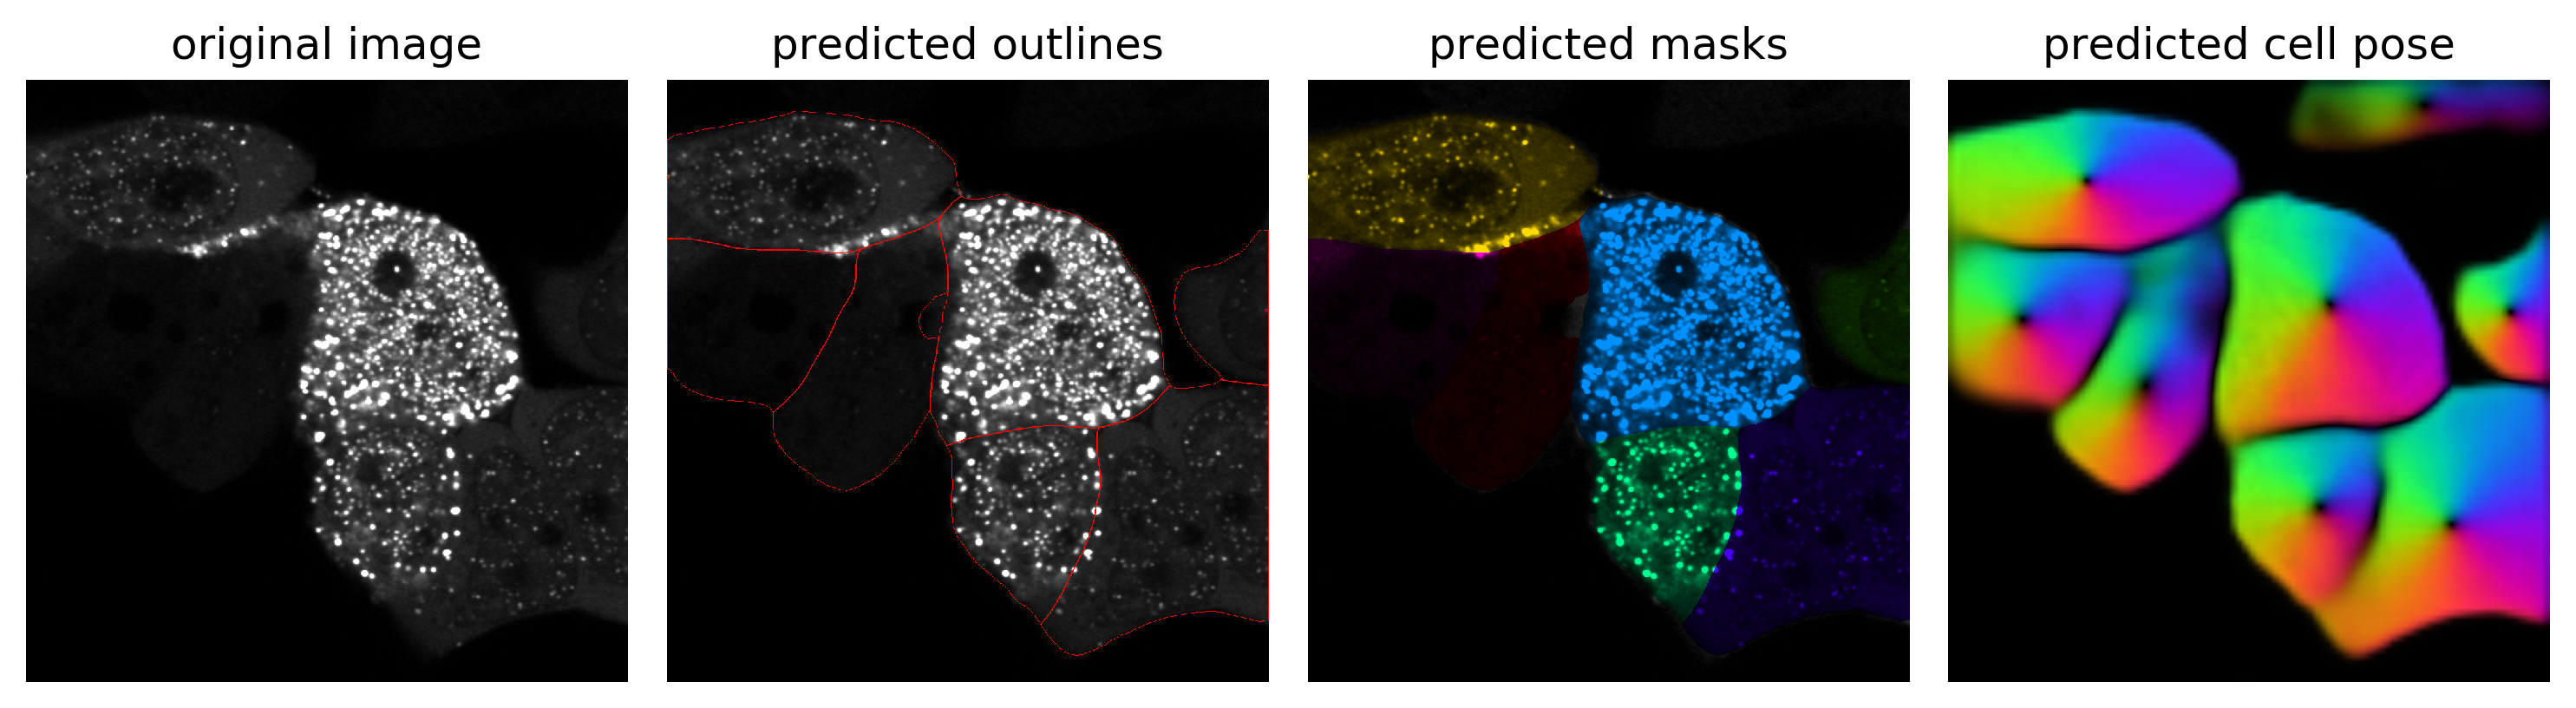

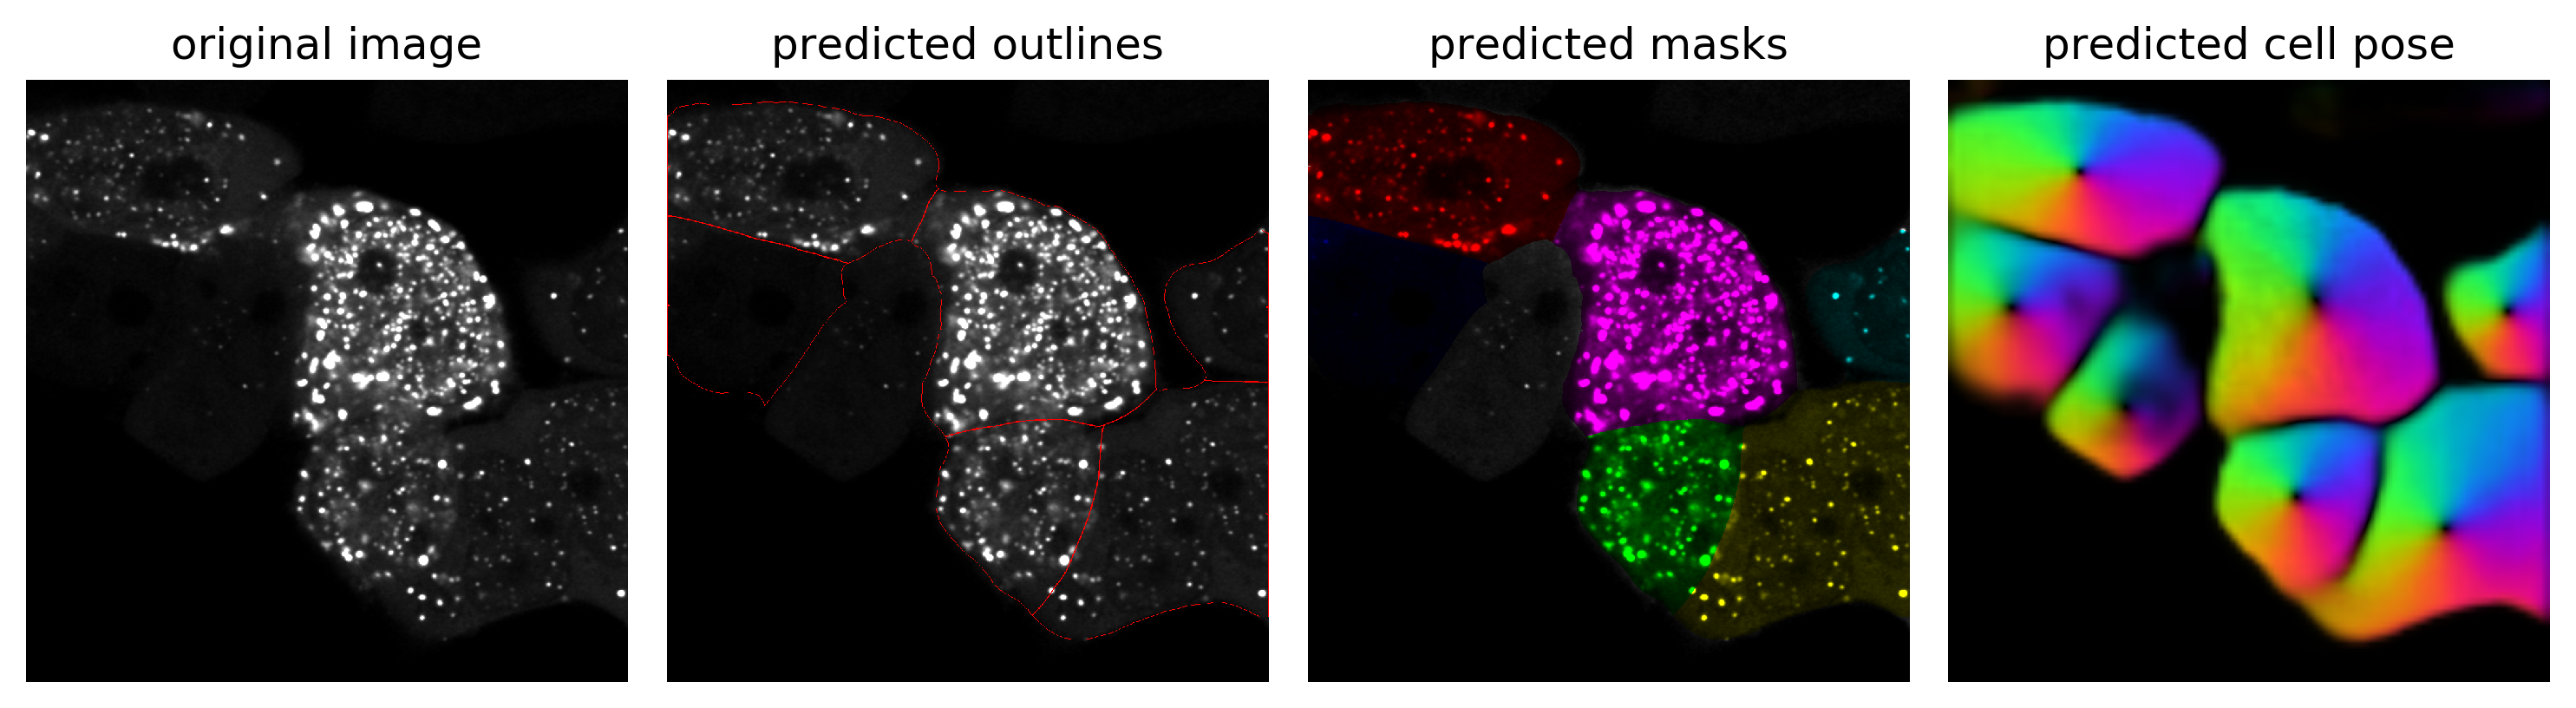

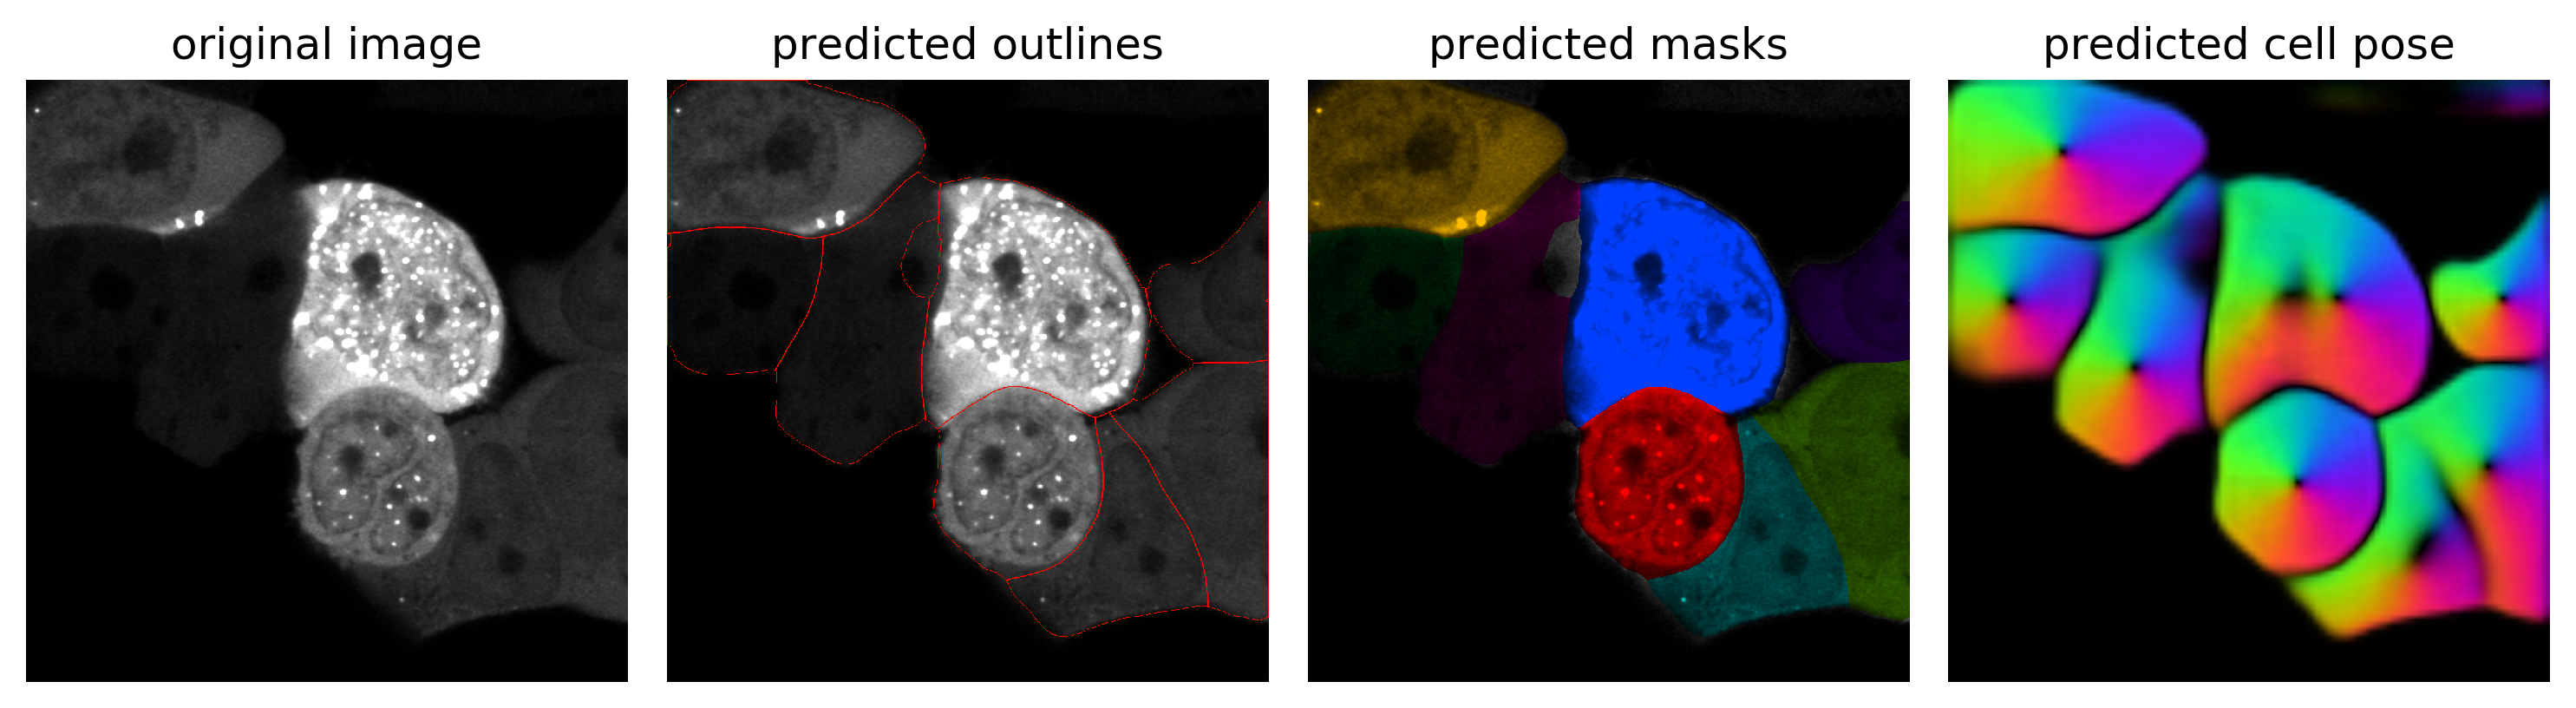

In [6]:
from cellpose import plot

nimg = len(imgs_2D)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(10,3))
    # plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    plt.show()

In [7]:
from cellpose import io

io.masks_flows_to_seg(imgs_2D, masks, flows, diams, files, channels)

## run cellpose 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks


In [10]:
# test 3D stack
# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model="./CP_testJIL_epoch500")
# use model diameter if user diameter is 0
diameter = model.diam_labels 
print(diameter)

# model = models.Cellpose(gpu=use_GPU, model_type='cyto'

# * with 3D you have to set the diameter manually (no auto detect) *
### TWO WAYS TO RUN CELLPOSE IN 3D
# 1. computes flows from 2D slices and combines into 3D flows to create masks
print('running cellpose 2D slice flows => masks')
imgs = [skimage.io.imread("file_full5.tif")]
img_3D = imgs[-1]
masks, flows, styles, _ = model.eval(img_3D, channels=[0,0], diameter=diameter, do_3D=True)

2023-11-22 11:49:17,462 [INFO] >>>> loading model ./CP_testJIL_epoch500
2023-11-22 11:49:17,464 [INFO] ** TORCH CUDA version installed and working. **
2023-11-22 11:49:17,465 [INFO] >>>> using GPU
2023-11-22 11:49:17,634 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-11-22 11:49:17,635 [INFO] >>>> model diam_labels =  296.739 (mean diameter of training ROIs)
296.73877
running cellpose 2D slice flows => masks
2023-11-22 11:49:17,743 [INFO] multi-stack tiff read in as having 5 planes 1 channels
2023-11-22 11:49:17,931 [INFO] running YX: 5 planes of size (1013, 1013)
2023-11-22 11:49:18,047 [INFO] 100%|##########| 1/1 [00:00<00:00,  9.03it/s]


ValueError: anisotropy too high / low -- not enough pixels to resize to ratio

In [90]:
# DISPLAY RESULTS 3D flows => masks
plt.figure(figsize=(15,3))
type(imgs)
len(imgs)



1

<Figure size 4500x900 with 0 Axes>

In [ ]:

for i,iplane in enumerate(np.arange(1,41,5,int)):
  print(i, iplane)
  img0 = plot.image_to_rgb(imgs[iplane, [1,0]].copy(), channels=[1,1])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

## Cellpose stitches -  time elapse images

Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [46]:
# test 3D stack
# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model="./CP_testJIL_epoch500")
# use model diameter if user diameter is 0
diameter = model.diam_labels 
print(diameter)

# model = models.Cellpose(gpu=use_GPU, model_type='cyto'

# * with 3D you have to set the diameter manually (no auto detect) *
### TWO WAYS TO RUN CELLPOSE IN 3D
# 1. computes flows from 2D slices and combines into 3D flows to create masks
print('running cellpose 2D slice flows => masks')
imgs = [skimage.io.imread("file_full.ome.tif")]
img_3D = imgs

# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, styles_stitched = model.eval(img_3D, channels=[2,1], diameter=diameter, do_3D=False, stitch_threshold=0.5)

2023-12-04 15:01:40,861 [INFO] >>>> loading model ./CP_testJIL_epoch500
2023-12-04 15:01:40,865 [INFO] ** TORCH CUDA version installed and working. **
2023-12-04 15:01:40,868 [INFO] >>>> using GPU
2023-12-04 15:01:41,126 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-12-04 15:01:41,127 [INFO] >>>> model diam_labels =  296.739 (mean diameter of training ROIs)
296.73877
running cellpose 2D slice flows => masks
running cellpose 2D + stitching masks
2023-12-04 15:01:41,301 [INFO] multi-stack tiff read in as having 41 planes 1 channels
2023-12-04 15:01:44,337 [INFO] 100%|##########| 41/41 [00:02<00:00, 14.48it/s]
2023-12-04 15:01:44,340 [INFO] network run in 2.84s
2023-12-04 15:03:35,696 [INFO] stitching 41 planes using stitch_threshold=0.500 to make 3D masks
2023-12-04 15:03:37,171 [INFO] masks created in 112.83s


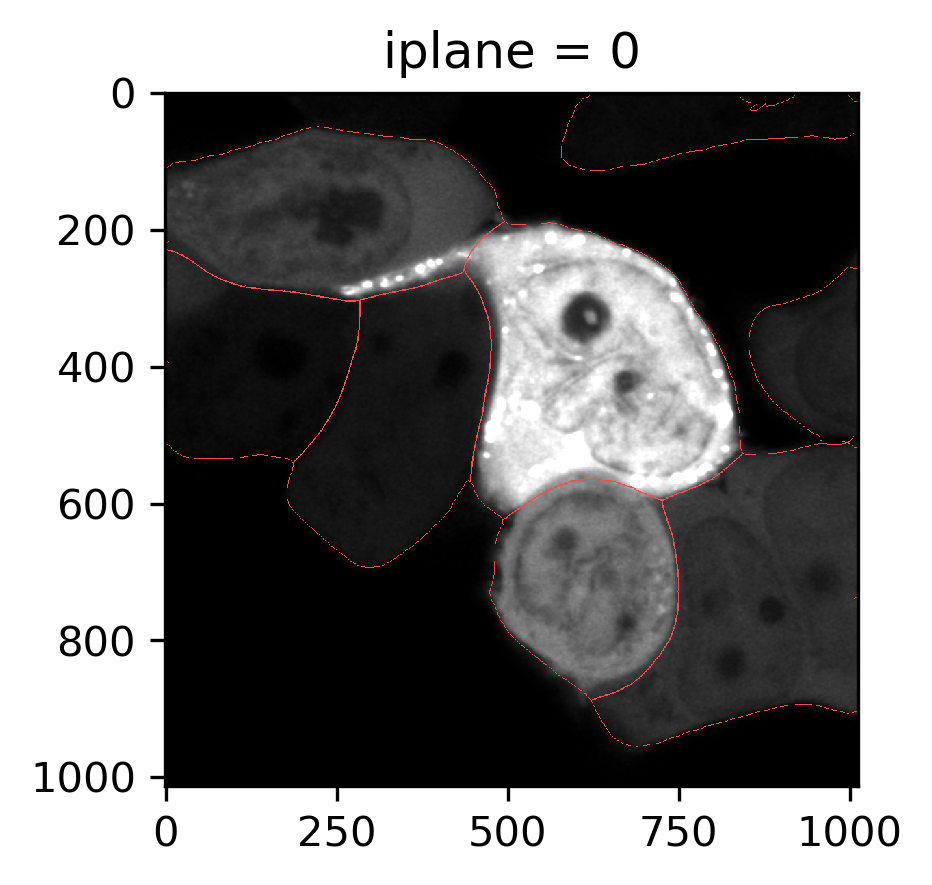

In [61]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming 'plot', 'utils', and 'masks' are defined elsewhere

plt.figure(figsize=(15, 3))

# Since img_3D.shape[0] is 1, we only process the first plane
iplane = 0
img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[0,0])

plt.subplot(1, 1, 1)  # Only one subplot as there is only one plane
outlines = utils.masks_to_outlines(masks[iplane])
outX, outY = np.nonzero(outlines)

imgout = img0.copy()
imgout[outX, outY] = np.array([255, 75, 75])
plt.imshow(imgout)
plt.title(f'iplane = {iplane}')

plt.show()


IndexError: index 620 is out of bounds for axis 1 with size 1

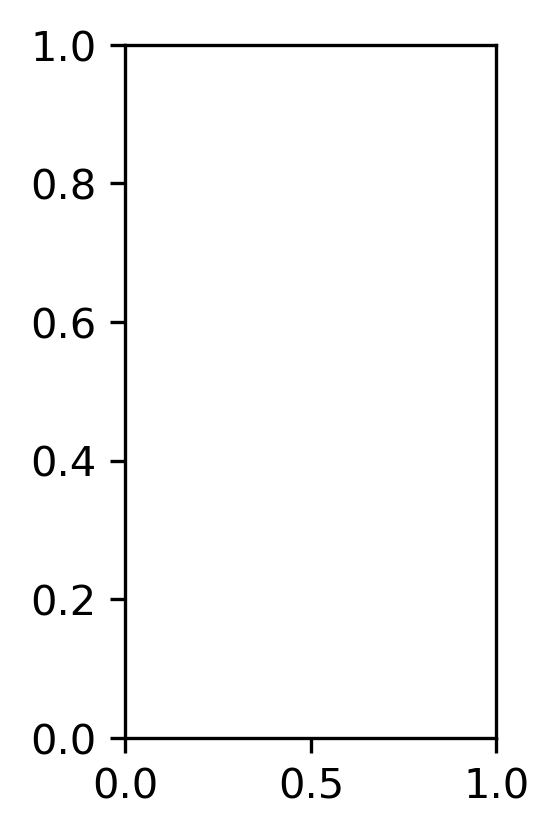

In [16]:
# DISPLAY RESULTS stitching
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks_stitched[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)